---
# Mounting Data

---
# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
!pip install colorama
import colorama
import time

torch.manual_seed(10)
sns.set()

import warnings
warnings.filterwarnings('ignore')

---
# Config

In [ ]:
num_workers = 2
batch_size = 128
n_epochs = 80
print_every_batch = 20
print_every_epoch = 5
image_size = 216
each_transform_probability = .7
total_transform_probability = .5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

---
# Dataset Class

There are many different transformations used for medical images depending on the problem like padding, zooming, random cropping, rotating, adding noise, etc. Here we will use 3 transforms, gaussian blurring, random rotating and random prespective. these transforms will generailize our model toward images that we see more frequently (like images with noise and different prespectives).

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

NORMAL_REL_PATH = '/NORMAL'
PNEUMONIA_REL_PATH = '/PNEUMONIA'

class XrayDataset(Dataset):
  def __init__(self, img_dir):
    self.img_dir = img_dir
    self.data_type = img_dir.split('/')[-1]
    self.normal_list = os.listdir(img_dir + NORMAL_REL_PATH)
    self.pneumonia_list = os.listdir(img_dir + PNEUMONIA_REL_PATH)
    self.transform = self.create_transform()

  def create_transform(self):
    transform_list = [
          transforms.RandomRotation(45) if np.random.rand() < each_transform_probability else None,
          transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 0.4)) if np.random.rand() < each_transform_probability else None,
          transforms.RandomPerspective(0.1, p=each_transform_probability)
    ]
    return torch.nn.Sequential(*[i for i in transform_list if i is not None])

  def __len__(self):
    return self.negative_size() + self.positive_size()

  def negative_size(self):
    return len(self.normal_list)

  def positive_size(self):
    return len(self.pneumonia_list)  

  def __getitem__(self, idx):
    if idx < len(self.normal_list):
      img_path = self.img_dir + NORMAL_REL_PATH +'/' + self.normal_list[idx]
      label = 0.
    else:
      img_path = self.img_dir + PNEUMONIA_REL_PATH + '/' + self.pneumonia_list[idx-len(self.normal_list)]
      label = 1.
    image = read_image(img_path)
    image = transforms.Resize((image_size, image_size))(image)
    if self.data_type  == 'train' and np.random.rand() < total_transform_probability:
      image = self.transform(image)
    image = image / 255 # normalize between 0 and 1
    if image.shape[0] > 1:
      image = torch.mean(image, dim=0).unsqueeze(0)
    return image, label

In [ ]:
# in kaggle kernel
train_data = XrayDataset('../input/chest-xray-pneumonia/chest_xray/train')
test_data = XrayDataset('../input/chest-xray-pneumonia/chest_xray/test')
val_data = XrayDataset('../input/chest-xray-pneumonia/chest_xray/val')

# in colab
# train_data = XrayDataset('./chest_xray/train')
# test_data = XrayDataset('./chest_xray/test')
# val_data = XrayDataset('./chest_xray/val')

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Datasets information

In [ ]:
print(f'Train Dataset size : {len(train_data)}, Number of positive : {train_data.positive_size()}, Number of negative : {train_data.negative_size()},')
print(f'Test Dataset size : {len(test_data)}, Number of positive : {test_data.positive_size()}, Number of negative : {test_data.negative_size()},')
print(f'Validation Dataset size : {len(val_data)}, Number of positive : {val_data.positive_size()}, Number of negative : {val_data.negative_size()},')

Train Dataset size : 5216, Number of positive : 3875, Number of negative : 1341,
Test Dataset size : 624, Number of positive : 390, Number of negative : 234,
Validation Dataset size : 16, Number of positive : 8, Number of negative : 8,


## Visualizing data

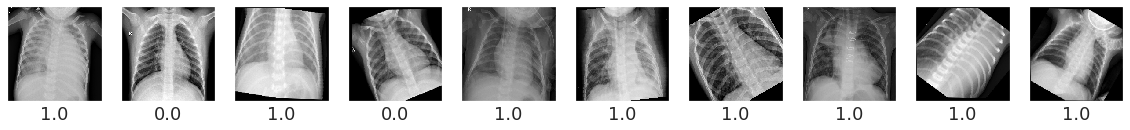

In [ ]:
plt.figure(figsize=(20,20))
data, target = next(iter(train_dataloader))
for i in range(10):
    img = data.squeeze(1)[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.xlabel(target[i].item(), fontsize=18)
    plt.xticks([])
    plt.yticks([])

---
# Defining Model Class
## Layers Output Shape
Because we use padding size $ \frac{k-1}{2} $ our output size will be $ \lfloor\frac{n+s-1}{s}\rfloor $
- Block 1 : $ 72 \times 72 $
- Block 2 : $ 24 \times 24 $
- Block 3 : $ 8 \times 8 $
- Linear : $ 2 $

## Dropout
Usually dropout is placed on the fully connected layers only because they are the one with the greater number of parameters and thus they're likely to cause overfitting. But we can use dropout in convolutional layers too. Here we will put dropout after each activation function of convolutional layers and test both a model with dropout and one  without.

## Channels
I tested different number of channels between two convolutional layers but there was signes of overfitting when dropout rate was zero (more than 20% accuracy difference between test and train) so I put only one channel to reduce models complexity whitout dropout.

In [ ]:
class Block(nn.Module):
  def __init__(self, filter_size, dropout_rate = 0):
    super(Block, self).__init__()
    middle_channel = 9 if dropout_rate > 0 else 1
    self.pad = int((filter_size-1) / 2)
    self.c1 = nn.Conv2d(in_channels=1, out_channels=middle_channel, kernel_size=(filter_size, filter_size), stride=3, padding=self.pad)
    self.normalize1 = nn.BatchNorm2d(middle_channel)
    self.c2 = nn.Conv2d(in_channels=middle_channel, out_channels=1, kernel_size=(filter_size, filter_size), padding=self.pad)
    self.normalize2 = nn.BatchNorm2d(1)
    self.dropout = nn.Dropout(dropout_rate)
    self.pool = nn.MaxPool2d(kernel_size=(filter_size, filter_size), stride=3, padding=self.pad)

  def forward(self, x):
    out = self.c1(x)
    out = self.normalize1(out)
    out = F.relu(out)
    out = self.dropout(out)

    out = self.c2(out)
    out = self.normalize2(out)

    # skip connection
    out = out + self.pool(x)

    out = F.relu(out)
    out = self.dropout(out)

    return out


class Network(nn.Module):
  def __init__(self,  dropout_rate=0):
    super(Network, self).__init__()
    self.b1 = Block(7, dropout_rate)
    self.b2 = Block(5, dropout_rate)
    self.b3 = Block(3, dropout_rate)
    self.f4 = nn.Linear(in_features=8*8, out_features=2)
    nn.init.xavier_uniform_(self.f4.weight)

  def forward(self, x):
    out = self.b1(x)
    out = self.b2(out)
    out = self.b3(out)
    out = out.view(out.shape[0], -1)
    out = self.f4(out)
    out = F.softmax(out, dim=-1)
    return out


## Network summary

In [ ]:
net = Network()
net.to(device)
print(net)

Network(
  (b1): Block(
    (c1): Conv2d(1, 1, kernel_size=(7, 7), stride=(3, 3), padding=(3, 3))
    (normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (dropout): Dropout(p=0, inplace=False)
    (pool): MaxPool2d(kernel_size=(7, 7), stride=3, padding=3, dilation=1, ceil_mode=False)
  )
  (b2): Block(
    (c1): Conv2d(1, 1, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout): Dropout(p=0, inplace=False)
    (pool): MaxPool2d(kernel_size=(5, 5), stride=3, padding=2, dilation=1, ceil_mode=False)
  )
  (b3): Block(
    (c1): Conv2d(1, 1, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): 

## Trainable parameters

In [ ]:
named_params = list(net.named_parameters())
print(f"len(params): {len(named_params)}")
for name, param in named_params:
    print(f"{name}:\t{param.shape}")

len(params): 20
b1.c1.weight:	torch.Size([1, 1, 7, 7])
b1.c1.bias:	torch.Size([1])
b1.normalize.weight:	torch.Size([1])
b1.normalize.bias:	torch.Size([1])
b1.c2.weight:	torch.Size([1, 1, 7, 7])
b1.c2.bias:	torch.Size([1])
b2.c1.weight:	torch.Size([1, 1, 5, 5])
b2.c1.bias:	torch.Size([1])
b2.normalize.weight:	torch.Size([1])
b2.normalize.bias:	torch.Size([1])
b2.c2.weight:	torch.Size([1, 1, 5, 5])
b2.c2.bias:	torch.Size([1])
b3.c1.weight:	torch.Size([1, 1, 3, 3])
b3.c1.bias:	torch.Size([1])
b3.normalize.weight:	torch.Size([1])
b3.normalize.bias:	torch.Size([1])
b3.c2.weight:	torch.Size([1, 1, 3, 3])
b3.c2.bias:	torch.Size([1])
f4.weight:	torch.Size([2, 64])
f4.bias:	torch.Size([2])


---
# Training the network
## Train function

In [ ]:
def train_network(model, train_loader, val_loader, test_loader, device, num_epochs=5, initial_lr=0.01, lr_decay=1.2):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
  criterion = nn.BCELoss()
  train_score_per_epoch = []
  val_score_per_epoch = []
  test_score_per_epoch = []
  loss_history = []

  for epoch in range(num_epochs):
    print(f"{'-'*30} starting epoch {epoch+1} {'-'*30}")
    
    for g in optimizer.param_groups: #changing learning rate of optimizer
        g['lr'] = initial_lr/(1+lr_decay*epoch)
    
    model.train()

    for batch_idx, (data, labels) in enumerate(train_loader):
      data, labels = data.to(device), labels.to(device).to(torch.float32)

      optimizer.zero_grad()
      output = model(data)[:, 1]
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      if ((batch_idx + 1) % print_every_batch) == 0:
        print(f"\tBatch {batch_idx+1}/{len(train_loader)}, Loss={loss.item():.4f}")

    loss_history.append(loss.item())
    if ((epoch + 1) % print_every_epoch) == 0:
      train_acc = accuracy(model, train_loader, device)
      val_acc = accuracy(model, val_loader, device)
      test_acc = accuracy(model, test_loader, device)

      train_score_per_epoch.append(train_acc)
      val_score_per_epoch.append(val_acc)
      test_score_per_epoch.append(test_acc)
      print(colorama.Fore.GREEN, f"\nAccuracy on training: {100*train_acc:.2f}%")
      print(f"Accuracy on validation: {100*val_acc:.2f}%")
      print(f"Accuracy on test: {100*test_acc:.2f}%", colorama.Fore.RESET)
  return loss_history, val_score_per_epoch, train_score_per_epoch, test_score_per_epoch

## Test functions

In [ ]:
from sklearn.metrics import confusion_matrix

def accuracy(model, dataloader, device):
  model.eval()
  num_currect = 0
  with torch.no_grad():
    for data, labels in dataloader:
      data, labels = data.to(device), labels.to(device)
      predictions = model(data).max(1)[1]
      num_currect += (predictions == labels).sum().item()
  return num_currect / len(dataloader.dataset)

def get_confusion_matrix(model, dataloader, device):
  model.eval()
  all_labels = torch.tensor([])
  all_preds = torch.tensor([])
  with torch.no_grad():
    for data, labels in dataloader:
      data, labels = data.to(device), labels
      predictions = model(data).max(1)[1]
      all_labels = torch.cat((all_labels, labels))
      all_preds = torch.cat((all_preds, predictions.cpu()))
  return confusion_matrix(all_labels, all_preds)

## Start the training
Training a model without dropout (dropout probability set to zero)

In [ ]:
net = Network()
net.to(device)
start_time = time.time()
loss_history, val_per_epoch, train_per_epoch, test_per_epoch =  train_network(net, train_dataloader, val_dataloader, test_dataloader, device, num_epochs=80, initial_lr=0.01)
execution_time = time.time()-start_time
print(colorama.Fore.BLUE, f'\nExcecution time : {execution_time / 60 :.0f} min {execution_time % 60 :.0f} sec', colorama.Fore.RESET)

------------------------------ starting epoch 1 ------------------------------
	Batch 20/41, Loss=0.6261
	Batch 40/41, Loss=0.4825
------------------------------ starting epoch 2 ------------------------------
	Batch 20/41, Loss=0.5083
	Batch 40/41, Loss=0.3534
------------------------------ starting epoch 3 ------------------------------
	Batch 20/41, Loss=0.4787
	Batch 40/41, Loss=0.3552
------------------------------ starting epoch 4 ------------------------------
	Batch 20/41, Loss=0.3577
	Batch 40/41, Loss=0.3303
------------------------------ starting epoch 5 ------------------------------
	Batch 20/41, Loss=0.4100
	Batch 40/41, Loss=0.3681
 
Accuracy on training: 76.27%
Accuracy on validation: 62.50%
Accuracy on test: 69.87% 
------------------------------ starting epoch 6 ------------------------------
	Batch 20/41, Loss=0.3436
	Batch 40/41, Loss=0.4776
------------------------------ starting epoch 7 ------------------------------
	Batch 20/41, Loss=0.3829
	Batch 40/41, Loss=0.

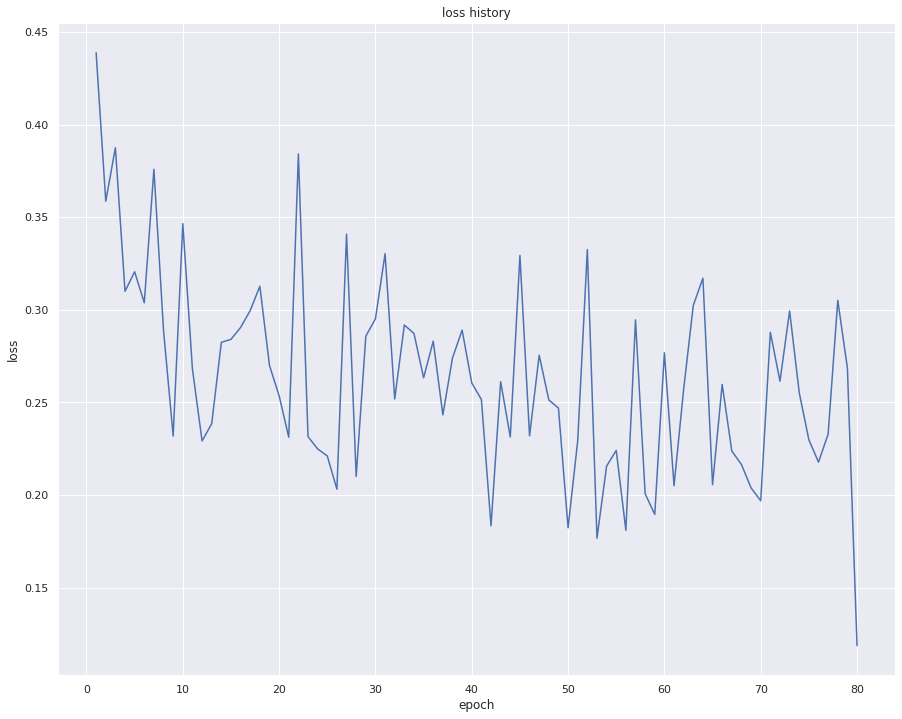

In [ ]:
plt.figure(figsize=(15, 12))
sns.lineplot(x=torch.arange(1, len(loss_history)+1), y=loss_history).set(title='loss history', ylabel='loss', xlabel='epoch');

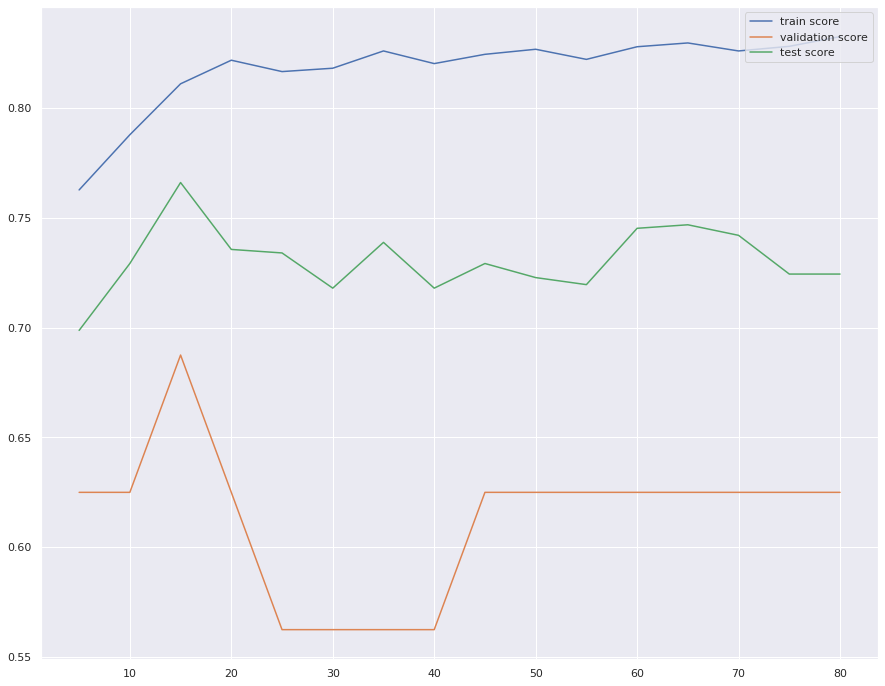

In [ ]:
plt.figure(figsize=(15, 12))
x = torch.arange(1, len(train_per_epoch)+1)*print_every_epoch
plt.plot(x, train_per_epoch, label='train score')
plt.plot(x, val_per_epoch, label='validation score')
plt.plot(x, test_per_epoch, label='test score')
plt.legend(loc='upper right')
plt.show()

Validation accuracy is a little all over the place because our validation data size is very low relative to test and train data size.

**Confusion Matrix**

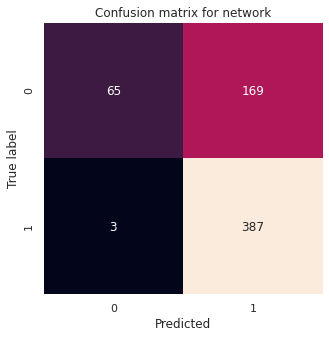

In [ ]:
confusion = get_confusion_matrix(net, test_dataloader, device)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion, cbar=False, annot=True, fmt='g').set(
    title='Confusion matrix for network', xlabel='Predicted', ylabel='True label');


Now let's train a model with dropout probability set to 0.4

In [ ]:
net_dropout = Network(dropout_rate=0.4)
net_dropout.to(device)
start_time = time.time()
loss_history_dropout, val_per_epoch_dropout, train_per_epoch_dropout, test_per_epoch_dropout =  train_network(net_dropout, train_dataloader, val_dataloader, test_dataloader, device, num_epochs=80, initial_lr=0.01)
execution_time = time.time()-start_time
print(colorama.Fore.BLUE, f'\nExcecution time : {execution_time / 60 :.0f} min {execution_time % 60 :.0f} sec', colorama.Fore.RESET)

------------------------------ starting epoch 1 ------------------------------
	Batch 20/41, Loss=8.2982
	Batch 40/41, Loss=14.5216
------------------------------ starting epoch 2 ------------------------------
	Batch 20/41, Loss=18.3744
	Batch 40/41, Loss=15.6600
------------------------------ starting epoch 3 ------------------------------
	Batch 20/41, Loss=19.3002
	Batch 40/41, Loss=23.8922
------------------------------ starting epoch 4 ------------------------------
	Batch 20/41, Loss=16.3881
	Batch 40/41, Loss=25.4695
------------------------------ starting epoch 5 ------------------------------
	Batch 20/41, Loss=21.0334
	Batch 40/41, Loss=18.3964
 
Accuracy on training: 70.49%
Accuracy on validation: 37.50%
Accuracy on test: 61.86% 
------------------------------ starting epoch 6 ------------------------------
	Batch 20/41, Loss=19.7825
	Batch 40/41, Loss=27.3338
------------------------------ starting epoch 7 ------------------------------
	Batch 20/41, Loss=22.9658
	Batch 40

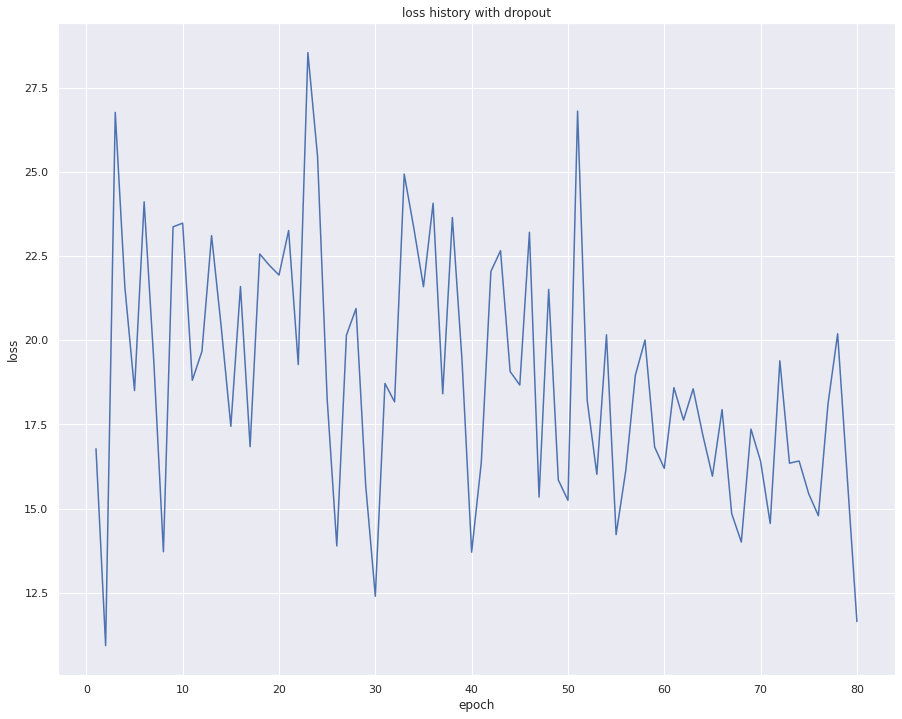

In [ ]:
plt.figure(figsize=(15, 12))
sns.lineplot(x=torch.arange(1, len(loss_history_dropout)+1), y=loss_history_dropout).set(title='loss history with dropout', ylabel='loss', xlabel='epoch');

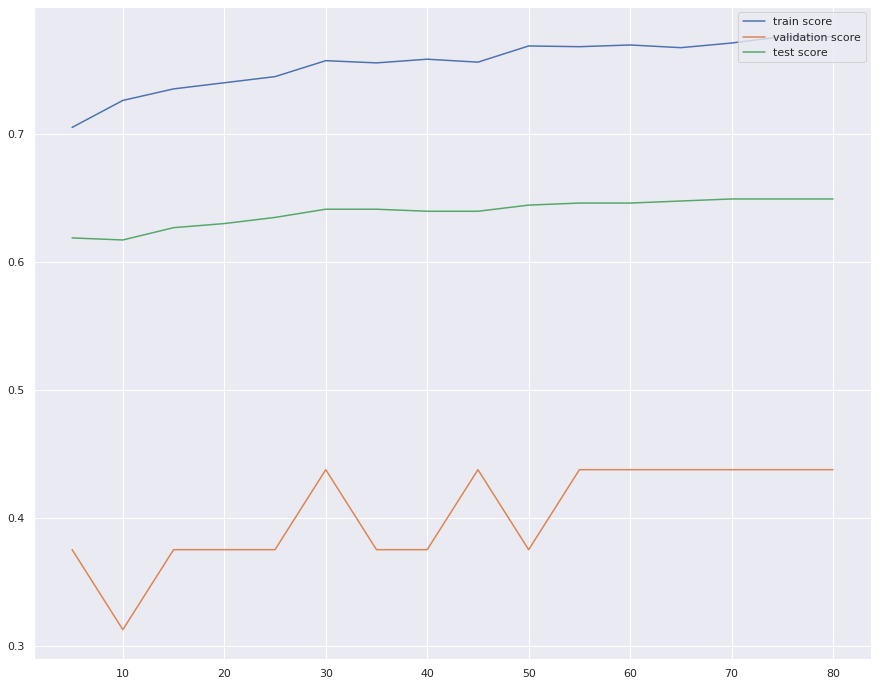

In [ ]:
plt.figure(figsize=(15, 12))
x = torch.arange(1, len(train_per_epoch_dropout)+1)*print_every_epoch
plt.plot(x, train_per_epoch_dropout, label='train score')
plt.plot(x, val_per_epoch_dropout, label='validation score')
plt.plot(x, test_per_epoch_dropout, label='test score')
plt.legend(loc='upper right')
plt.show()

**Confusion matrix**

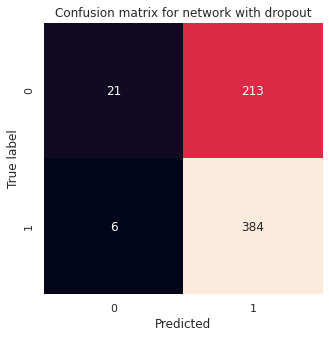

In [ ]:
confusion_dropout = get_confusion_matrix(net_dropout, test_dataloader, device)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_dropout, cbar=False, annot=True, fmt='g').set(
    title='Confusion matrix for network with dropout', xlabel='Predicted', ylabel='True label');